In [1]:
import polars as pl
import plotnine as p9
from p9customtheme import custom_theme, custom_discrete
from cstbioinfo.embedding import EmbedderModel
from cstbioinfo.embedding.tl import umap
from functools import partial

# Define a partial function for UMAP with specific parameters
# So that all models are using the same parameters
umap_partial = partial(umap, n_neighbors=50, min_dist=0.5)

In [2]:
# Download a example dataset from OAS
url = "https://opig.stats.ox.ac.uk/webapps/ngsdb/paired/Alsoiussi_2020/csv/SRR11528761_paired.csv.gz"
n = 300
df = pl.read_csv(url, has_header=True, skip_rows=1, separator=",", n_rows=n)


In [3]:
# Initialize the embedder model
model = EmbedderModel.PIGGEN
embedder = EmbedderModel.get_embedder(model)

print(f"Downloaded {df.shape[0]} example sequences from OAS.")

Downloaded 300 example sequences from OAS.


In [4]:
# Embed the sequences, this can take a while depending on the model and your hardware
embeddings = embedder.embed(
    df.get_column("sequence_alignment_aa_heavy").to_list(), batch_size=1
)
print(f"Embedded {len(embeddings)} sequences with shape {embeddings[0].shape}.")

Embedding sequences: 100%|██████████| 300/300 [00:22<00:00, 13.32it/s]

Embedded 300 sequences with shape torch.Size([768]).


In [5]:
# quickly make a umap from the embeddings, this can then be combined with the original dataframe
df_umap = umap_partial(embeddings)
df_umap = df_umap.rename(lambda column_name: f"{model.name}_{column_name}")
print(f"Reduced the embeddings to {df_umap.shape} dimensions with UMAP.")

Reduced the embeddings to (300, 2) dimensions with UMAP.


In [6]:
# Add the UMAP embeddings to the original dataframe
df_embedding = pl.concat([df, df_umap], how="horizontal")


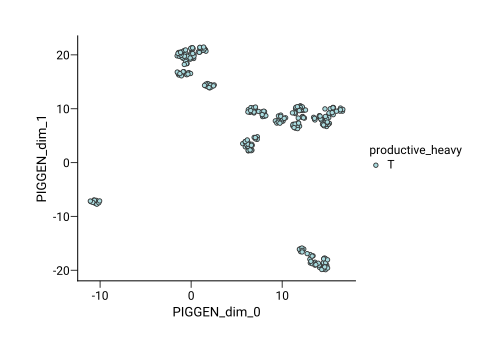

In [7]:
(
    p9.ggplot(
        df_embedding,
        p9.aes(x="PIGGEN_dim_0", y="PIGGEN_dim_1", fill="productive_heavy"),
    )
    + p9.geom_point()
    + custom_discrete()
)

In [ ]:
# Now the same embedding can be done with a different model, e.g. ANARCII
model = EmbedderModel.ANARCII
embedder = EmbedderModel.get_embedder(model, model_type="antibody")  # Default model
embeddings = embedder.embed(df.get_column("sequence_alignment_aa_heavy").to_list())
print(f"Embedded {len(embeddings)} sequences with shape {embeddings[0].shape}.")
df_umap = umap_partial(embeddings)
df_umap = df_umap.rename(lambda column_name: f"{model.name}_{column_name}")
print(f"Reduced the embeddings to {df_umap.shape} dimensions with UMAP.")
df_embedding = pl.concat([df_embedding, df_umap], how="horizontal")

Embedding sequences: 100%|██████████| 10/10 [00:00<00:00, 56.29it/s]



Embedded 300 sequences with shape torch.Size([128]).
Reduced the embeddings to (300, 2) dimensions with UMAP.
Reduced the embeddings to (300, 2) dimensions with UMAP.


In [ ]:
# Now the same embedding can be done with a different model from ANARCII, e.g. TCR
model = EmbedderModel.ANARCII
embedder = EmbedderModel.get_embedder(model, model_type="tcr")
embeddings = embedder.embed(df.get_column("sequence_alignment_aa_heavy").to_list())
print(f"Embedded {len(embeddings)} sequences with shape {embeddings[0].shape}.")
anarci_tcr_df = umap_partial(embeddings)
print(f"Reduced the embeddings to {anarci_tcr_df.shape} dimensions with UMAP.")
anarci_tcr_df = anarci_tcr_df.with_columns(pl.lit("ANARCII (TCR)").alias("model"))

Embedding sequences: 100%|██████████| 10/10 [00:00<00:00, 56.92it/s]



Embedded 300 sequences with shape torch.Size([128]).
Reduced the embeddings to (300, 2) dimensions with UMAP.
Reduced the embeddings to (300, 2) dimensions with UMAP.


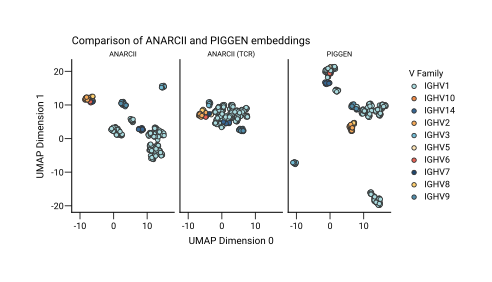

In [ ]:
df_subset = df_embedding.with_columns(
    pl.col("v_call_heavy").str.split("-").list.first().alias("v_family_heavy")
).select(
    "v_family_heavy",
    "ANARCII_dim_0",
    "ANARCII_dim_1",
    "PIGGEN_dim_0",
    "PIGGEN_dim_1",
)
anarci_df = (
    df_subset.select(["v_family_heavy", "ANARCII_dim_0", "ANARCII_dim_1"])
    .rename({"ANARCII_dim_0": "dim_0", "ANARCII_dim_1": "dim_1"})
    .with_columns(pl.lit("ANARCII").alias("model"))
)
piggen_df = (
    df_subset.select(["v_family_heavy", "PIGGEN_dim_0", "PIGGEN_dim_1"])
    .rename({"PIGGEN_dim_0": "dim_0", "PIGGEN_dim_1": "dim_1"})
    .with_columns(pl.lit("PIGGEN").alias("model"))
)
anarci_tcr_df = anarci_tcr_df.with_columns(
    pl.Series(anarci_df.get_column("v_family_heavy"))
)

embeddings = pl.concat([anarci_df, piggen_df, anarci_tcr_df], how="diagonal_relaxed")
(
    p9.ggplot(embeddings, p9.aes(x="dim_0", y="dim_1", fill="v_family_heavy"))
    + p9.geom_point()
    + p9.facet_wrap("model")
    + p9.coord_fixed()
    + custom_discrete()
    + custom_theme(base_size=9)
    + p9.theme(figure_size=(8, 3))
    + p9.labs(
        title="Comparison of ANARCII and PIGGEN embeddings",
        x="UMAP Dimension 0",
        y="UMAP Dimension 1",
        fill="V Family",
    )
)

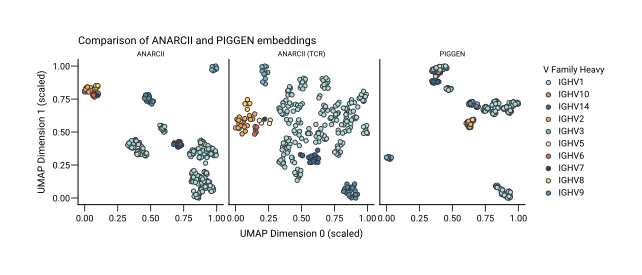

In [ ]:
# to plot them all in the same plot we can scale the coordinates to the same range
# for each model we do this separately
dfs = [anarci_df, piggen_df, anarci_tcr_df]
scaled_dfs = []
for df_m in dfs:
    df_m = df_m.with_columns(
        (
            (pl.col("dim_0") - pl.col("dim_0").min())
            / (pl.col("dim_0").max() - pl.col("dim_0").min())
        ).alias("dim_0"),
        (
            (pl.col("dim_1") - pl.col("dim_1").min())
            / (pl.col("dim_1").max() - pl.col("dim_1").min())
        ).alias("dim_1"),
    )
    scaled_dfs.append(df_m)
scaled_embeddings = pl.concat(scaled_dfs, how="diagonal_relaxed")

(
    p9.ggplot(scaled_embeddings, p9.aes(x="dim_0", y="dim_1", fill="v_family_heavy"))
    + p9.geom_point()
    + p9.facet_wrap("model")
    + p9.coord_fixed()
    + custom_discrete()
    + custom_theme(base_size=9)
    + p9.theme(figure_size=(8, 3))
    + p9.labs(
        title="Comparison of ANARCII and PIGGEN embeddings",
        x="UMAP Dimension 0 (scaled)",
        y="UMAP Dimension 1 (scaled)",
        fill="V Family",
    )
)
